> **Objectives**<br>
> 
> 1. Build a model that can predict the health of a bee hive by analyzing images of bees.
> 2. Deploy the model as a prototype web based tool that bee keepers and researchers can use. They should be able to submit a picture of a bee and  instantly get an assessment of the health of the hive where the bee lives.

This kernel will focus on:

1. Creating a directory structure
2. Creating generators
3. Data augmentation
4. Model building and training
5. Assessing the quality of the model via a confusion matrix and F1 score.

**Results**

The model's validation accuracy and F1 score are greater than 0.9

****

All the html, css, and javascript code used to build the web app is available on Github.

Web app:<br>
http://bee.test.woza.work/<br>
Github:<br>
https://github.com/vbookshelf/Bee-Hive-Health-Analyzer


In [1]:
import numpy as np
from numpy.random import seed

set_random_seed = np.random.seed

import pandas as pd

#import keras

import tensorflow
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.metrics import categorical_accuracy

import os


from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import itertools
import shutil
import matplotlib.pyplot as plt
%matplotlib inline



**A lesson learned...**

In this kernel we are using tf.keras and not native Keras. tf.keras is Keras that lives within Tensorflow.

When using native Keras I found that the accuracy as calculated manually from the confusion matrix does not match the accuracy obtained during training and evaluation. The problem was soved when I switched to tf.keras. I think there's a problem with predict_generator() in native Keras or maybe I'm using it wrong.

Another complication is that a tf.keras model cannot be converted into a Tensorflowjs model for use in the app. To solve this problem I had to create another kernel using native Keras and convert that model to Tensorflowjs - a complicated story, I know :-)


In [2]:
# To reduce the class imbalance in the train and validation set, the number of 
# rows in class 'healthy' will be reduced to this number:

HEALTHY_SAMPLE_SIZE = 579

# The approx. total number of images we want in each class after doing image augmentation.
# We won't be doing image augmentation on the fly.
NUM_IMAGES_WANTED = 3000 # incl. class 'healthy'

# MobileNet needs input images with shape 224x224x3
IMAGE_SIZE = 224
IMAGE_CHANNELS = 3

IMAGE_PATH = "C://Users/user/Desktop/Vic/Bee-Hive-Health-Analyzer-master/honey-bee-annotated images/bee_imgs/bee_imgs"

In [3]:
# What files are available?

os.listdir("C://Users/user/Desktop/Vic/Bee-Hive-Health-Analyzer-master/honey-bee-annotated images/bee_imgs/bee_imgs")

['001_043.png',
 '001_044.png',
 '001_046.png',
 '001_047.png',
 '001_050.png',
 '001_051.png',
 '001_054.png',
 '001_056.png',
 '001_078.png',
 '001_082.png',
 '001_083.png',
 '001_085.png',
 '001_091.png',
 '001_092.png',
 '001_093.png',
 '001_094.png',
 '001_095.png',
 '001_096.png',
 '001_097.png',
 '001_118.png',
 '001_120.png',
 '001_121.png',
 '001_122.png',
 '001_124.png',
 '001_126.png',
 '001_127.png',
 '001_131.png',
 '001_132.png',
 '001_133.png',
 '001_134.png',
 '001_135.png',
 '001_138.png',
 '001_140.png',
 '001_144.png',
 '001_145.png',
 '001_147.png',
 '001_149.png',
 '001_151.png',
 '001_152.png',
 '001_156.png',
 '001_159.png',
 '001_160.png',
 '001_163.png',
 '001_164.png',
 '001_167.png',
 '001_168.png',
 '001_169.png',
 '001_171.png',
 '001_172.png',
 '001_173.png',
 '002_022.png',
 '002_023.png',
 '002_024.png',
 '002_026.png',
 '002_030.png',
 '002_031.png',
 '002_033.png',
 '002_034.png',
 '002_035.png',
 '002_037.png',
 '002_044.png',
 '002_046.png',
 '002_05

### LABELS
What are the labels and what is the class distribution?

In [4]:
df = pd.read_csv('bee_data.csv')
df['health'].value_counts()

healthy                       3384
few varrao, hive beetles       579
Varroa, Small Hive Beetles     472
ant problems                   457
hive being robbed              251
missing queen                   29
Name: health, dtype: int64

### Create the directory structure

In these folders we will store the images that will later be fed to the Keras generators. 

In [5]:
# Key:
# healthy = healthy
# fvar = few varrao, hive beetles
# var = Varroa, Small Hive Beetles
# ant = ant problems
# robbed = hive being robbed
# queen = missing queen

# Create a new directory
base_dir = 'base_dir'
os.mkdir(base_dir)


#[CREATE FOLDERS INSIDE THE BASE DIRECTORY]

# train_dir
    # 1_healthy
    # 2_fvar
    # 3_var
    # 4_ant
    # 5_robbed
    # 6_queen
 
# val_dir
    # 1_healthy
    # 2_fvar
    # 3_var
    # 4_ant
    # 5_robbed
    # 6_queen

# create a path to 'base_dir' to which we will join the names of the new folders

# train_dir
train_dir = os.path.join(base_dir, 'train_dir')
os.mkdir(train_dir)

# val_dir
val_dir = os.path.join(base_dir, 'val_dir')
os.mkdir(val_dir)


# [CREATE FOLDERS INSIDE THE TRAIN AND VALIDATION FOLDERS]
# Inside each folder we create seperate folders for each class

# create new folders inside train_dir
healthy = os.path.join(train_dir, '1_healthy')
os.mkdir(healthy)
fvar = os.path.join(train_dir, '2_fvar')
os.mkdir(fvar)
var = os.path.join(train_dir, '3_var')
os.mkdir(var)
ant = os.path.join(train_dir, '4_ant')
os.mkdir(ant)
robbed = os.path.join(train_dir, '5_robbed')
os.mkdir(robbed)
queen = os.path.join(train_dir, '6_queen')
os.mkdir(queen)


# create new folders inside val_dir
healthy = os.path.join(val_dir, '1_healthy')
os.mkdir(healthy)
fvar = os.path.join(val_dir, '2_fvar')
os.mkdir(fvar)
var = os.path.join(val_dir, '3_var')
os.mkdir(var)
ant = os.path.join(val_dir, '4_ant')
os.mkdir(ant)
robbed = os.path.join(val_dir, '5_robbed')
os.mkdir(robbed)
queen = os.path.join(val_dir, '6_queen')
os.mkdir(queen)



FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'base_dir'

### Create Train and Val Sets

In [6]:
df_data = pd.read_csv('bee_data.csv')

df_data.head()

,file,date,time,location,zip code,subspecies,health,pollen_carrying,caste
0,041_066.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
1,041_072.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
2,041_073.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
3,041_067.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
4,041_059.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker


### Downsample the 'healthy' class to reduce the class imbalance

In [7]:
# take a random sample of class 'healthy'
df = df_data[df_data['health'] == 'healthy'].sample(HEALTHY_SAMPLE_SIZE, random_state=101)

# remove class 'healthy' from the dataframe
df_data = df_data[df_data['health'] != 'healthy']

# concat df and df_data
df_data = pd.concat([df_data, df], axis=0).reset_index(drop=True)

# shuffle the new dataframe
df_data = shuffle(df_data)

# check the new class distribution
df_data['health'].value_counts()

few varrao, hive beetles      579
healthy                       579
Varroa, Small Hive Beetles    472
ant problems                  457
hive being robbed             251
missing queen                  29
Name: health, dtype: int64

### Creat train and val sets

In [8]:

y = df_data['health']

df_train, df_val = train_test_split(df_data, test_size=0.1, random_state=101, stratify=y)

print(df_train.shape)
print(df_val.shape)

(2130, 9)
(237, 9)


In [9]:
df_train['health'].value_counts()

few varrao, hive beetles      521
healthy                       521
Varroa, Small Hive Beetles    425
ant problems                  411
hive being robbed             226
missing queen                  26
Name: health, dtype: int64

In [10]:
df_val['health'].value_counts()

healthy                       58
few varrao, hive beetles      58
Varroa, Small Hive Beetles    47
ant problems                  46
hive being robbed             25
missing queen                  3
Name: health, dtype: int64

In [11]:
# Set the 'file' column as the index in df_data
df_data.set_index('file', inplace=True)

In [12]:

# Get a list of train and val images
train_list = list(df_train['file'])
val_list = list(df_val['file'])

# Key:
# healthy = healthy
# fvar = few varrao, hive beetles
# var = Varroa, Small Hive Beetles
# ant = ant problems
# robbed = hive being robbed
# queen = missing queen



# Transfer the train images.
# Note that we re-name the files during the transfer using a number sequence. This is just a
# safety measure help the generators create a repeatable sequence of images. 


length = len(train_list)

for i in range(0,length):
    
    fname = train_list[i]
    image = fname
    description = df_data.loc[image,'health']
    
    # map the class descriptions to folder names
    if description == 'healthy':
        label = '1_healthy'
    if description == 'few varrao, hive beetles':
        label = '2_fvar'
    if description == 'Varroa, Small Hive Beetles':
        label = '3_var'
    if description == 'ant problems':
        label = '4_ant'
    if description == 'hive being robbed':
        label = '5_robbed'
    if description == 'missing queen':
        label = '6_queen'
        
        
    # source path to image
    src = os.path.join('C://Users/user/Desktop/Vic/Bee-Hive-Health-Analyzer-master/honey-bee-annotated images/bee_imgs/bee_imgs', fname)
    # chage the file name
    new_name = str(i) + '_' + 'train'+ '.png'
    # destination path to image
    dst = os.path.join(train_dir, label, new_name)
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)


# Transfer the val images

length = len(val_list)

for i in range(0,length):
    
    fname = val_list[i]
    image = fname
    description = df_data.loc[image,'health']
    
     # map the class descriptions to folder names
    if description == 'healthy':
        label = '1_healthy'
    if description == 'few varrao, hive beetles':
        label = '2_fvar'
    if description == 'Varroa, Small Hive Beetles':
        label = '3_var'
    if description == 'ant problems':
        label = '4_ant'
    if description == 'hive being robbed':
        label = '5_robbed'
    if description == 'missing queen':
        label = '6_queen'
    
    # source path to image
    src = os.path.join('C://Users/user/Desktop/Vic/Bee-Hive-Health-Analyzer-master/honey-bee-annotated images/bee_imgs/bee_imgs', fname)
    # chage the file name
    new_name = str(i) + '_' + 'val' + '.png'
    # destination path to image
    dst = os.path.join(val_dir, label, new_name)
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)

        

NameError: name 'train_dir' is not defined

In [13]:
# check how many train images we have in each folder

print(len(os.listdir('base_dir/train_dir/1_healthy')))
print(len(os.listdir('base_dir/train_dir/2_fvar')))
print(len(os.listdir('base_dir/train_dir/3_var')))
print(len(os.listdir('base_dir/train_dir/4_ant')))
print(len(os.listdir('base_dir/train_dir/5_robbed')))
print(len(os.listdir('base_dir/train_dir/6_queen')))


3001
3001
2973
2985
2919
2895


In [14]:
# check how many val images we have in each folder

print(len(os.listdir('base_dir/val_dir/1_healthy')))
print(len(os.listdir('base_dir/val_dir/2_fvar')))
print(len(os.listdir('base_dir/val_dir/3_var')))
print(len(os.listdir('base_dir/val_dir/4_ant')))
print(len(os.listdir('base_dir/val_dir/5_robbed')))
print(len(os.listdir('base_dir/val_dir/6_queen')))


58
58
47
46
25
3


In [15]:
# note that we are not augmenting class 'healthy'
class_list = ['1_healthy', '2_fvar','3_var','4_ant','5_robbed','6_queen']

for item in class_list:
    
    # We are creating temporary directories here because we delete these directories later.
    
    # create a base dir
    aug_dir = 'aug_dir'
    os.mkdir(aug_dir)
    # create a dir within the base dir to store images of the same class
    img_dir = os.path.join(aug_dir, 'img_dir')
    os.mkdir(img_dir)

    # Choose a class
    img_class = item

    # list all images in that directory
    img_list = os.listdir('base_dir/train_dir/' + img_class)

    # Copy images from the class train dir to the img_dir e.g. class 'healthy'
    for fname in img_list:
            # source path to image
            src = os.path.join('base_dir/train_dir/' + img_class, fname)
            # destination path to image
            dst = os.path.join(img_dir, fname)
            # copy the image from the source to the destination
            shutil.copyfile(src, dst)


    # point to a dir containing the images and NOT to the images themselves
    path = aug_dir
    save_path = 'base_dir/train_dir/' + img_class

    # Create a data generator to generate augmented images for each class.
    datagen = ImageDataGenerator(
        #rotation_range=180,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.01,
        #horizontal_flip=True,
        #vertical_flip=True,
        brightness_range=(0.9,1.1),
        fill_mode='nearest')

    batch_size = 9

    aug_datagen = datagen.flow_from_directory(path,
                                        save_to_dir=save_path, # this is where the images are saved
                                        save_format='jpg',
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=batch_size)



    # Generate the augmented images and add them to the training folders
    
    # NUM_IMAGES_WANTED = total number of images we want to have in each class
    # We will use image augmentation to create the additional images.
    
    num_files = len(os.listdir(img_dir))
    
    # Just a calculation to get approx. the same amount of images for each class.
    num_batches = int(np.ceil((NUM_IMAGES_WANTED-num_files)/batch_size))

    # Run the generator and create augmented images.
    # Note that these images are automatically stored in a folder. The path
    # to the save folder is specified as a parameter in the generator above.
    for i in range(0,num_batches):

        imgs, labels = next(aug_datagen)
        
    # delete temporary directory with the raw image files
    shutil.rmtree('aug_dir')

Found 3001 images belonging to 1 classes.
Found 3001 images belonging to 1 classes.
Found 2973 images belonging to 1 classes.
Found 2985 images belonging to 1 classes.
Found 2919 images belonging to 1 classes.
Found 2895 images belonging to 1 classes.


In [16]:
# Check how many train images we now have in each folder.
# This is the original images plus the augmented images.

print(len(os.listdir('base_dir/train_dir/1_healthy')))
print(len(os.listdir('base_dir/train_dir/2_fvar')))
print(len(os.listdir('base_dir/train_dir/3_var')))
print(len(os.listdir('base_dir/train_dir/4_ant')))
print(len(os.listdir('base_dir/train_dir/5_robbed')))
print(len(os.listdir('base_dir/train_dir/6_queen')))

3001
3001
3000
3003
3000
3003


In [17]:
# Check how many val images we have in each folder.

print(len(os.listdir('base_dir/val_dir/1_healthy')))
print(len(os.listdir('base_dir/val_dir/2_fvar')))
print(len(os.listdir('base_dir/val_dir/3_var')))
print(len(os.listdir('base_dir/val_dir/4_ant')))
print(len(os.listdir('base_dir/val_dir/5_robbed')))
print(len(os.listdir('base_dir/val_dir/6_queen')))

58
58
47
46
25
3


### Visualize a batch of augmented images

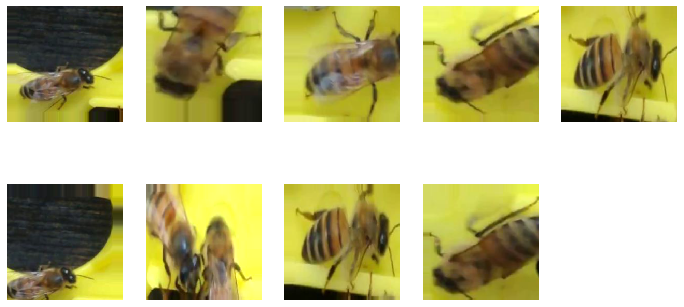

In [18]:
# plots images with labels within jupyter notebook
# source: https://github.com/smileservices/keras_utils/blob/master/utils.py

def plots(ims, figsize=(12,6), rows=2, interp=False, titles=None): # 12,6
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')
        
plots(imgs, titles=None) # titles=labels will display the image labels

In [ ]:
# End of Data Preparation
### ===================================================================================== ###
# Start of Model Building

### Set Up the Generators

In [19]:
train_path = 'base_dir/train_dir'
valid_path = 'base_dir/val_dir'

num_train_samples = len(df_train)
num_val_samples = len(df_val)
train_batch_size = 10
val_batch_size = 10
image_size = 224

train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)


#### A Note on Image Pre-propcessing to Suit MobileNet

We will be applying the same pre-processing to the bee images as was applied to the original ImageNet  images that were used to train MobileNet. We will add this pre-processing as a preprocessing_function in the generators below.

In [20]:

datagen = ImageDataGenerator(preprocessing_function=
                             tensorflow.keras.applications.mobilenet.preprocess_input)

train_gen = datagen.flow_from_directory(train_path,
                                        target_size=(image_size,image_size),
                                        batch_size=train_batch_size,
                                        class_mode='categorical')

val_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(image_size,image_size),
                                        batch_size=val_batch_size,
                                        class_mode='categorical')

# Note: shuffle=False causes the test dataset to not be shuffled.
# Here we will be using the val set as the test dataset because we need to run predict
# in order to generate the confusion matrix.
test_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(image_size,image_size),
                                        batch_size=1,
                                        class_mode='categorical',
                                        shuffle=False)

Found 18008 images belonging to 6 classes.
Found 237 images belonging to 6 classes.
Found 237 images belonging to 6 classes.


### Modify MobileNet Model

In [21]:
# Create a copy of a mobilenet model.
# Please ensure your kaggle kernel is set to 'Internet Connected'.

mobile = tensorflow.keras.applications.mobilenet.MobileNet()

In [22]:
mobile.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32

In [23]:
type(mobile.layers)

list

In [24]:
# How many layers does MobileNet have?
len(mobile.layers)

93

In [26]:
# CREATE THE MODEL ARCHITECTURE

# Exclude the last 5 layers of the above model.
# This will include all layers up to and including global_average_pooling2d_1
x = mobile.layers[-6].output

# Create a new dense layer for predictions
# 6 corresponds to the number of classes
#x = Dropout(0.25)(x)
predictions = Dense(6, activation='softmax')(x)

# inputs=mobile.input selects the input layer, outputs=predictions refers to the
# dense layer we created above.

model = Model(inputs=mobile.input, outputs=predictions)

In [27]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128 

In [28]:
# We need to choose how many layers we actually want to be trained.

# Here we are freezing the weights of all layers except the
# last 23 layers in the new model.
# The last 23 layers of the model will be trained.

for layer in model.layers[:-23]:
    layer.trainable = False

### Train the Model

In [29]:
model.compile(Adam(lr=0.001), loss='categorical_crossentropy', 
              metrics=['accuracy'])


In [58]:
from keras.callbacks import ModelCheckpoint
import h5py
filepath = "model.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2, 
                                   verbose=1, mode='max', min_lr=0.00001)
                              
                              
callbacks_list = [checkpoint, reduce_lr]

history = model.fit_generator(train_gen, steps_per_epoch=train_steps, 
                            validation_data=val_gen,
                            validation_steps=val_steps,
                            epochs=10, verbose=1,
                           callbacks=callbacks_list)


  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 213.0 steps, validate for 24.0 steps
Epoch 1/10
212/213 [============================>.] - ETA: 0s - loss: 0.1313 - accuracy: 0.9571
Epoch 00001: val_accuracy improved from -inf to 0.68354, saving model to model.hdf5
213/213 [==============================] - 164s 768ms/step - loss: 0.1327 - accuracy: 0.9563 - val_loss: 1.3110 - val_accuracy: 0.6835
Epoch 2/10
212/213 [============================>.] - ETA: 1s - loss: 0.1009 - accuracy: 0.9651
Epoch 00002: val_accuracy improved from 0.68354 to 0.77637, saving model to model.hdf5
213/213 [==============================] - 265s 1s/step - loss: 0.1005 - accuracy: 0.9653 - val_loss: 0.8092 - val_accuracy: 0.7764
Epoch 3/10
212/213 [============================>.] - ETA: 0s - loss: 0.1011 - accuracy: 0.9660
Epoch 00003: val_accuracy improved from 0.77637 to 0.81435, saving model to model.hdf5
213/213 [==============================] - 190s 891ms/step - loss: 0.1009 - accuracy: 0.96

### Evaluate the model using the val set


In [48]:
# Get the metric names so that we can see what the output from evaulate_generator will be.
model.metrics_names

['loss', 'accuracy']

We see that the output metrics are loss and accuracy. Therefore, we now know that model.evaluate_generator() outputs val loss and val accuracy. 

In [60]:
# Here the best epoch will be used.

model.load_weights('model.hdf5')

val_loss, val_accuracy = \
model.evaluate_generator(test_gen, 
                        steps=len(df_val))

print('val_loss:', val_loss)
print('val_acc:', val_accuracy)


  ...
    to  
  ['...']
val_loss: 0.21669253850811565
val_acc: 0.9409283


### Plot the Training Curves

ValueError: x and y must have same first dimension, but have shapes (10,) and (1,)

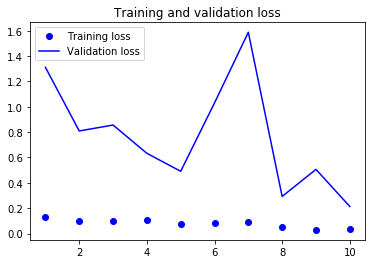

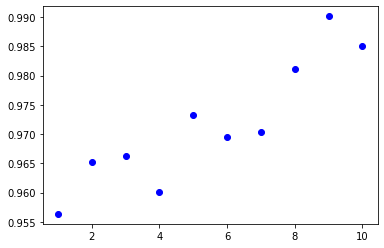

In [61]:
# display the loss and accuracy curves

import matplotlib.pyplot as plt

accuracy = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

plt.plot(epochs, accuracy, 'bo', label='Training acc')
plt.plot(epochs, val_accuracy, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()


### Create a Confusion Matrix

The confusion matrix and F1 score will tell us how well our model is able to perform on each individual class. 

In [62]:
# make a prediction
from tensorflow.keras.models import load_model

predictions = model.predict_generator(test_gen, steps=len(df_val), verbose=1)

Instructions for updating:
Please use Model.predict, which supports generators.
237/237 [==============================] - 34s 142ms/step


In [63]:
# Get the index of the class with the highest probability score
y_pred = np.argmax(predictions, axis=1)

# Get the labels of the test images.
y_true = test_gen.classes

In [64]:
# Source: Scikit Learn website
# http://scikit-learn.org/stable/auto_examples/
# model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-
# selection-plot-confusion-matrix-py


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.figure(figsize=(100,100))
    plt.tight_layout()




In [65]:
# argmax returns the index of the max value in a row
cm = confusion_matrix(y_true, y_pred)

In [66]:
test_gen.class_indices

{'1_healthy': 0,
 '2_fvar': 1,
 '3_var': 2,
 '4_ant': 3,
 '5_robbed': 4,
 '6_queen': 5}

Confusion matrix, without normalization
[[57  0  0  0  1  0]
 [ 0 50  6  1  1  0]
 [ 1  3 43  0  0  0]
 [ 0  0  0 46  0  0]
 [ 0  0  0  1 24  0]
 [ 0  0  0  0  0  3]]


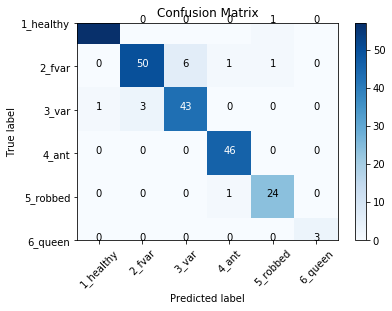

<Figure size 7200x7200 with 0 Axes>

In [67]:
# Key:
# healthy = healthy
# fvar = few varrao, hive beetles
# var = Varroa, Small Hive Beetles
# ant = ant problems
# robbed = hive being robbed
# queen = missing queen

# Define the labels of the class indices. These need to match the 
# order shown above.
cm_plot_labels = ['1_healthy', '2_fvar', '3_var', '4_ant', '5_robbed','6_queen']

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

In [68]:
len(df_val)

237

### Generate the Classification Report

In [69]:
# Get the filenames, labels and associated predictions

# This outputs the sequence in which the generator processed the test images
test_filenames = test_gen.filenames


In [70]:
from sklearn.metrics import classification_report

# Generate a classification report

names = ['healthy', 'few varrao, hive beetles', 'Varroa, Small Hive Beetles', 
               'ant problems', 'hive being robbed','missing queen']

report = classification_report(y_true, y_pred, target_names=names)

print(report)

                            precision    recall  f1-score   support

                   healthy       0.98      0.98      0.98        58
  few varrao, hive beetles       0.94      0.86      0.90        58
Varroa, Small Hive Beetles       0.88      0.91      0.90        47
              ant problems       0.96      1.00      0.98        46
         hive being robbed       0.92      0.96      0.94        25
             missing queen       1.00      1.00      1.00         3

                  accuracy                           0.94       237
                 macro avg       0.95      0.95      0.95       237
              weighted avg       0.94      0.94      0.94       237



**Recall ** = Given a class, will the classifier be able to detect it?<br>
**Precision** = Given a class prediction from a classifier, how likely is it to be correct?<br>
**F1 Score** = The harmonic mean of the recall and precision. Essentially, it punishes extreme values.


The accuracy is above 90%. The F1 score is also above 90%. This tells us that our model is really good at detecting all classes, even the 'missing queen' class where only a 29  images are available.

*As a side note - I'm wondering if the model is performing so well because it's looking at the bees or if it is actually looking at the background colour of the images. Maybe a more experienced data scientist can answer this question.*

In [ ]:
# End of Model Building
### ===================================================================================== ###
# Convert the Model from Keras to Tensorflow.js

### What is Tensorflow.js?

Tensorflow.js is a new library that allows machine learning models to run in the browser - without having to download or install any additional software. Because the model is running locally, any data that a user submits never leaves his or her pc or mobile phone. 

Every image that a user submits needs to be pre-processed before being passed to the model for prediction. MobileNet pre-prcessing involves scaling the pixel values between 1 and -1. In this kernel we used a built in function to pre-process images for MobileNet:<br>
tensorflow.keras.applications.mobilenet.preprocess_input()

When using Tensorflowjs in the app, this pre-processing needs to be implemented manually.


*The code that follows could run in Kaggle kernels a few days ago, now it can't. <br>
"import tensorflowjs as tfjs" gives an error.*

*I've included the model conversion steps for reference - because I'm sure the error will be fixed at some point.*

### Install Tensorflow.js

In [73]:
pip install tensorflowjs

Note: you may need to restart the kernel to use updated packages.


### Convert the model from Keras to Tensorflow.js

In [9]:
# create a directory to store the model files
import os
os.mkdir('tfjs_dir')

# convert to Tensorflow.js
import tensorflowjs as tfjs

tfjs.converters.save_keras_model(model, 'tfjs_dir')

NameError: name 'model' is not defined

In [3]:
# check the the directory containing the model is available
ls

NameError: name 'ls' is not defined

In [4]:
# view the files that make up the tensorflow.js model
os.listdir('tfjs_dir')

[]

### Delete base_dir

In [ ]:
# Delete the image data directory we created to prevent a Kaggle error.
# Kaggle allows a max of 500 files to be saved.

shutil.rmtree('base_dir')

### Resources

These are some helpful resources:

1. Excellent tutorial series by deeplizard on how to use Mobilenet with Tensorflow.js<br>
https://www.youtube.com/watch?v=HEQDRWMK6yY

2. Tutorial by Minsuk Heo on Accuracy, Precision and F1 Score<br>
https://www.youtube.com/watch?v=HBi-P5j0Kec

3. Tutorial by Data School on how to evaluate a classifier<br>
https://www.youtube.com/watch?v=85dtiMz9tSo

3. Tensorflow.js gallery of projects<br>
https://github.com/tensorflow/tfjs/blob/master/GALLERY.md

